<a href="https://colab.research.google.com/github/nicedaddy/Euro-Truck-Simulator-2-Lane-Assist/blob/main/Lane_Detection%2C_Lane_Assist_System_%EB%B9%B5%ED%98%95%EC%9D%98_%EA%B0%9C%EB%B0%9C%EB%8F%84%EC%83%81%EA%B5%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lane Assist System

> 유튜브 [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

- Original repository: https://github.com/cfzd/Ultra-Fast-Lane-Detection-v2
- for ETS2: https://github.com/Tumppi066/Euro-Truck-Simulator-2-Lane-Assist
- with cars: https://github.com/jason-li-831202/Vehicle-CV-ADAS

![](https://github.com/jason-li-831202/Vehicle-CV-ADAS/raw/master/demo/demo-gif.gif)

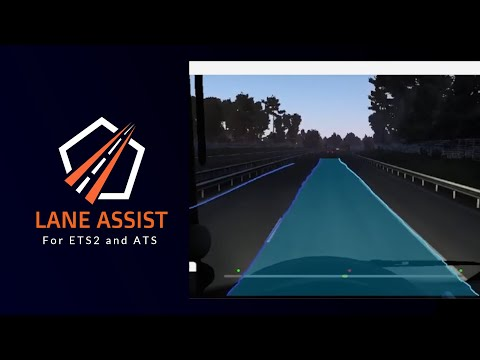

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('XmM87rA_3fw', width=1280, height=720)

## Install dependency

In [ ]:
!git clone -q https://github.com/Tumppi066/Euro-Truck-Simulator-2-Lane-Assist.git
%cd /content/Euro-Truck-Simulator-2-Lane-Assist/plugins/UFLDLaneDetection/UFLD
!pip install -q onnxruntime-gpu onnx addict

/content/Euro-Truck-Simulator-2-Lane-Assist/plugins/UFLDLaneDetection/UFLD
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


## Download the model

<img src="https://i.imgur.com/IzNrB6I.png" width="600px">

In [ ]:
!gdown 1pkz8homK433z39uStGK3ZWkDXrnBAMmX

Downloading...
From: https://drive.google.com/uc?id=1pkz8homK433z39uStGK3ZWkDXrnBAMmX
To: /content/Euro-Truck-Simulator-2-Lane-Assist/plugins/UFLDLaneDetection/UFLD/tusimple_res34.pth
100% 426M/426M [00:02<00:00, 142MB/s]


## Convert the model

PyTorch -> ONNX

In [ ]:
from convertPytorchToONNX import convert_model
from ultrafastLaneDetector.utils import LaneModelType, OffsetType, lane_colors, tusimple_row_anchor, culane_row_anchor

convert_model("tusimple_res34.pth", LaneModelType.UFLDV2_TUSIMPLE)

Model Type :  UFLDV2_TUSIMPLE


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.6MB/s]


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Network helpers

In [ ]:
# @title
import numpy as np
import onnxruntime
import time, os

def _softmax(x) :
	exp_x = np.exp(x)
	return exp_x/np.sum(exp_x)

class ModelConfig():

	def __init__(self, model_type):

		if model_type == LaneModelType.UFLDV2_TUSIMPLE:
			self.init_tusimple_config()
		else:
			self.init_culane_config()
		self.num_lanes = 4

	def init_tusimple_config(self):
		self.img_w = 800
		self.img_h = 320
		self.row_anchor = tusimple_row_anchor
		self.griding_num = 100
		self.crop_ratio = 0.8
		self.row_anchor = np.linspace(160,710, 56)/720
		self.col_anchor = np.linspace(0,1, 41)

	def init_culane_config(self):
		self.img_w = 1600
		self.img_h = 320
		self.row_anchor = culane_row_anchor
		self.griding_num = 200
		self.crop_ratio = 0.6
		self.row_anchor = np.linspace(0.42,1, 72)
		self.col_anchor = np.linspace(0,1, 81)

class OnnxEngine():

	def __init__(self, onnx_file_path, useGPU=True):
		if (onnxruntime.get_device() == 'GPU' and useGPU) :
			self.session = onnxruntime.InferenceSession(onnx_file_path, providers=['CUDAExecutionProvider'])
			print("ONNX Running with GPU support.")
		else :
			self.session = onnxruntime.InferenceSession(onnx_file_path, providers=['CPUExecutionProvider'])
			print("ONNX Running with CPU support.")
		self.providers = self.session.get_providers()

	def  get_onnx_input_shape(self):
		return self.session.get_inputs()[0].shape


	def  get_onnx_output_shape(self):
		output_shape = [output.shape for output in self.session.get_outputs()]
		output_names = [output.name for output in self.session.get_outputs()]
		if (len(output_names) != 4) :
			raise Exception("Output dims is error, please check model. load %d channels not match 4." % len(self.output_names))
		return output_shape, output_names

	def inference(self, input_tensor):
		input_name = self.session.get_inputs()[0].name
		output_names = [output.name for output in self.session.get_outputs()]
		output = self.session.run(output_names, {input_name: input_tensor})

		return output

class UltrafastLaneDetectorV2():
	_defaults = {
		"model_path": "models/culane_res18.onnx",
		"model_type" : LaneModelType.UFLDV2_TUSIMPLE,
	}

	@classmethod
	def set_defaults(cls, config) :
		cls._defaults = config

	@classmethod
	def check_defaults(cls):
		return cls._defaults

	@classmethod
	def get_defaults(cls, n):
		if n in cls._defaults:
			return cls._defaults[n]
		else:
			return "Unrecognized attribute name '" + n + "'"

	def __init__(self, model_path=None, model_type=None, logger=None):
		if (None in [model_path, model_type]) :
			self.__dict__.update(self._defaults) # set up default values
		else :
			self.model_path = model_path
			self.model_type = model_type
		self.logger = logger

		if ( self.model_type not in [LaneModelType.UFLDV2_TUSIMPLE, LaneModelType.UFLDV2_CULANE]) :
			if (self.logger) :
				self.logger.error("UltrafastLaneDetectorV2 can use %s type." % self.model_type.name)
			raise Exception("UltrafastLaneDetectorV2 can use %s type." % self.model_type.name)

		self.fps = 0
		self.timeLastPrediction = time.time()
		self.frameCounter = 0
		self.draw_area_points = []
		self.draw_area = False

		# Load model configuration based on the model type
		self.cfg = ModelConfig(self.model_type)

		# Initialize model
		self._initialize_model(self.model_path, self.cfg)

	def _initialize_model(self, model_path, cfg):
		if (self.logger) :
			self.logger.debug("model path: %s." % model_path)
		if not os.path.isfile(model_path):
			raise Exception("The model path [%s] can't not found!" % model_path)

		self.framework_type = "onnx"
		self.infer = OnnxEngine(model_path)
		self.providers = self.infer.providers

		# Get model info
		self.getModel_input_details()
		self.getModel_output_details()
		if (self.logger) :
			self.logger.info(f'UfldDetector Type : [{self.framework_type}] || Version : [{self.providers}]')

	def getModel_input_details(self):
		if (self.framework_type == "trt") :
			self.input_shape = self.infer.get_tensorrt_input_shape()
		else :
			self.input_shape = self.infer.get_onnx_input_shape()
		self.channes = self.input_shape[1]
		self.input_height = self.input_shape[2]
		self.input_width = self.input_shape[3]

	def getModel_output_details(self):
		if (self.framework_type == "trt") :
			self.output_shape = self.infer.get_tensorrt_output_shape()
		else :
			self.output_shape, self.output_names = self.infer.get_onnx_output_shape()

	def prepare_input(self, image):
		img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		self.img_height, self.img_width, self.img_channels = img.shape


		# Input values should be from -1 to 1 with a size of 288 x 800 pixels
		new_size = ( self.input_width, int(self.input_height/self.cfg.crop_ratio))
		img_input = cv2.resize(img, new_size).astype(np.float32)
		img_input = img_input[-self.input_height:, :, :]
		# Scale input pixel values to -1 to 1
		mean=[0.485, 0.456, 0.406]
		std=[0.229, 0.224, 0.225]

		img_input = ((img_input/ 255.0 - mean) / std)
		img_input = img_input.transpose(2, 0, 1)
		img_input = img_input[np.newaxis,:,:,:]

		return img_input.astype(np.float32)

	def DetectFrame(self, image) :
		input_tensor = self.prepare_input(image)

		# Perform inference on the image
		output = self.infer.inference(input_tensor)

		# Process output data
		self.lanes_points, self.lanes_detected = self.process_output(output, self.cfg, original_image_width =  self.img_width, original_image_height = self.img_height)

	def DrawDetectedOnFrame(self, image, type=OffsetType.UNKNOWN) :
		for lane_num,lane_points in enumerate(self.lanes_points):
			if ( lane_num==1 and type == OffsetType.RIGHT) :
				color = (0, 0, 255)
			elif (lane_num==2 and type == OffsetType.LEFT) :
				color = (0, 0, 255)
			else :
				color = lane_colors[lane_num]
			for lane_point in lane_points:
				cv2.circle(image, (lane_point[0],lane_point[1]), 3, color, -1)

	def DrawAreaOnFrame(self, image, color=(255,191,0)) :
		self.draw_area = False
		# Draw a mask for the current lane
		if(self.lanes_detected != []) :
			if(self.lanes_detected[1] and self.lanes_detected[2]):
				self.draw_area = True
				lane_segment_img = image.copy()
				left_lanes_points, right_lanes_points = self.adjust_lanes_points(self.lanes_points[1], self.lanes_points[2], self.img_height)
				self.draw_area_points = [np.vstack((left_lanes_points,np.flipud(right_lanes_points)))]
				cv2.fillPoly(lane_segment_img, pts = self.draw_area_points, color =color)
				image = cv2.addWeighted(image, 0.7, lane_segment_img, 0.1, 0)

		if (not self.draw_area) : self.draw_area_points = []
		return image

	def AutoDrawLanes(self, image, draw_points=True):

		input_tensor = self.prepare_input(image)

		# Perform inference on the image
		output = self.infer.inference(input_tensor)

		# Process output data
		try:
			self.lanes_points, self.lanes_detected = self.process_output(output, self.cfg, original_image_width =  self.img_width, original_image_height = self.img_height)
		except:
			import traceback
			traceback.print_exc()

		# # Draw depth image
		visualization_img = self.draw_lanes(image, self.lanes_points, self.lanes_detected, draw_points, original_image_width =  self.img_width, original_image_height = self.img_height)

		return visualization_img

	def adjust_lanes_points(self, left_lanes_points, right_lanes_points, image_height) :
		# 多项式拟合
		if (len(left_lanes_points[1]) != 0 ) :
			leftx, lefty  = list(zip(*left_lanes_points))
		else :
			return left_lanes_points, right_lanes_points
		if (len(right_lanes_points) != 0 ) :
			rightx, righty  = list(zip(*right_lanes_points))
		else :
			return left_lanes_points, right_lanes_points

		if len(lefty) > 10:
			self.left_fit = np.polyfit(lefty, leftx, 2)
		if len(righty) > 10:
			self.right_fit = np.polyfit(righty, rightx, 2)

		# Generate x and y values for plotting
		maxy = image_height - 1
		miny = image_height // 3
		if len(lefty):
			maxy = max(maxy, np.max(lefty))
			miny = min(miny, np.min(lefty))

		if len(righty):
			maxy = max(maxy, np.max(righty))
			miny = min(miny, np.min(righty))

		ploty = np.linspace(miny, maxy, image_height)

		left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
		right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

		# Visualization
		fix_left_lanes_points = []
		fix_right_lanes_points = []
		for i, y in enumerate(ploty):
			l = int(left_fitx[i])
			r = int(right_fitx[i])
			y = int(y)
			if (y >= min(lefty)) :
				fix_left_lanes_points.append((l, y))
			if (y >= min(righty)) :
				fix_right_lanes_points.append((r, y))
				# cv2.line(out_img, (l, y), (r, y), (0, 255, 0))
		return fix_left_lanes_points, fix_right_lanes_points

	@staticmethod
	def process_output(pred, cfg, local_width = 1, original_image_width = 1640, original_image_height = 590):

		output = {"loc_row" : pred[0], 'loc_col' : pred[1], "exist_row" : pred[2], "exist_col" : pred[3]}
		# print(output["loc_row"].shape)
		# print(output["exist_row"].shape)
		# print(output["loc_col"].shape)
		# print(output["exist_col"].shape)

		batch_size, num_grid_row, num_cls_row, num_lane_row = output['loc_row'].shape
		batch_size, num_grid_col, num_cls_col, num_lane_col = output['loc_col'].shape

		max_indices_row = output['loc_row'].argmax(1)
		# n , num_cls, num_lanes
		valid_row = output['exist_row'].argmax(1)
		# n, num_cls, num_lanes

		max_indices_col = output['loc_col'].argmax(1)
		# n , num_cls, num_lanes
		valid_col = output['exist_col'].argmax(1)
		# n, num_cls, num_lanes

		output['loc_row'] = output['loc_row']
		output['loc_col'] = output['loc_col']
		row_lane_idx = [1,2]
		col_lane_idx = [0,3]

		# Parse the output of the model
		lanes_points = {"left-side" : [], "left-ego" : [] , "right-ego" : [], "right-side" : []}
		# lanes_detected = []
		lanes_detected =  {"left-side" : False, "left-ego" : False , "right-ego" : False, "right-side" : False}
		for i in row_lane_idx:
			tmp = []
			if valid_row[0,:,i].sum() > num_cls_row / 2:
				for k in range(valid_row.shape[1]):
					if valid_row[0,k,i]:
						all_ind = list(range(max(0,max_indices_row[0,k,i] - local_width), min(num_grid_row-1, max_indices_row[0,k,i] + local_width) + 1))
						out_tmp = ( _softmax(output['loc_row'][0,all_ind,k,i]) * list(map(float, all_ind))).sum() + 0.5
						out_tmp = out_tmp / (num_grid_row-1) * original_image_width
						tmp.append((int(out_tmp), int(cfg.row_anchor[k] * original_image_height)))
				if (i == 1) :
					lanes_points["left-ego"].extend(tmp)
					if (len(tmp) > 2) :
						lanes_detected["left-ego"] = True
				else :
					lanes_points["right-ego"].extend(tmp)
					if (len(tmp) > 2) :
						lanes_detected["right-ego"] = True

		for i in col_lane_idx:
			tmp = []
			if valid_col[0,:,i].sum() > num_cls_col / 4:
				for k in range(valid_col.shape[1]):
					if valid_col[0,k,i]:
						all_ind = list(range(max(0,max_indices_col[0,k,i] - local_width), min(num_grid_col-1, max_indices_col[0,k,i] + local_width) + 1))
						out_tmp = ( _softmax(output['loc_col'][0,all_ind,k,i]) * list(map(float, all_ind))).sum() + 0.5
						out_tmp = out_tmp / (num_grid_col-1) * original_image_height
						tmp.append((int(cfg.col_anchor[k] * original_image_width), int(out_tmp)))
				if (i == 0) :
					lanes_points["left-side" ].extend(tmp)
					if (len(tmp) > 2) :
						lanes_detected["left-side"] = True
				else :
					lanes_points["right-side"].extend(tmp)
					if (len(tmp) > 2) :
						lanes_detected["right-side"] = True

		#print(lanes_detected)
		return list(lanes_points.values()), list(lanes_detected.values())

	@staticmethod
	def draw_lanes(input_img, lanes_points, lanes_detected, cfg, draw_points=True, original_image_width = 1640, original_image_height = 590):
		# Write the detected line points in the image
		visualization_img = cv2.resize(input_img, (original_image_width, original_image_height), interpolation = cv2.INTER_AREA)

		# Draw a mask for the current lane
		if(lanes_detected != []) :
			if(lanes_detected[1] and lanes_detected[2]):
				lane_segment_img = visualization_img.copy()

				cv2.fillPoly(lane_segment_img, pts = [np.vstack((lanes_points[1],np.flipud(lanes_points[2])))], color =(255,191,0))
				visualization_img = cv2.addWeighted(visualization_img, 0.7, lane_segment_img, 0.3, 0)

		if(draw_points):
			for lane_num,lane_points in enumerate(lanes_points):
				for lane_point in lane_points:
					cv2.circle(visualization_img, (lane_point[0],lane_point[1]), 3, lane_colors[lane_num], -1)

		return visualization_img

## Load the model

In [ ]:
model_path = "tusimple_res34.onnx"
model_type = LaneModelType.UFLDV2_TUSIMPLE

laneDetector = UltrafastLaneDetectorV2(model_path, model_type)

ONNX Running with GPU support.


## Test dataset

Dataset: https://www.kaggle.com/datasets/manideep1108/tusimple

In [ ]:
!wget https://raw.githubusercontent.com/kairess/toy-datasets/master/lanes.zip
!unzip lanes.zip -d lanes

--2023-10-13 05:49:56--  https://raw.githubusercontent.com/kairess/toy-datasets/master/lanes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1211359 (1.2M) [application/zip]
Saving to: ‘lanes.zip’

lanes.zip           100%[===================>]   1.15M  --.-KB/s    in 0.006s  

2023-10-13 05:49:57 (178 MB/s) - ‘lanes.zip’ saved [1211359/1211359]

Archive:  lanes.zip
  inflating: lanes/1.jpg             
  inflating: lanes/2.jpg             
  inflating: lanes/3.jpg             
  inflating: lanes/4.jpg             
  inflating: lanes/5.jpg             
  inflating: lanes/6.jpg             
  inflating: lanes/7.jpg             


## Test

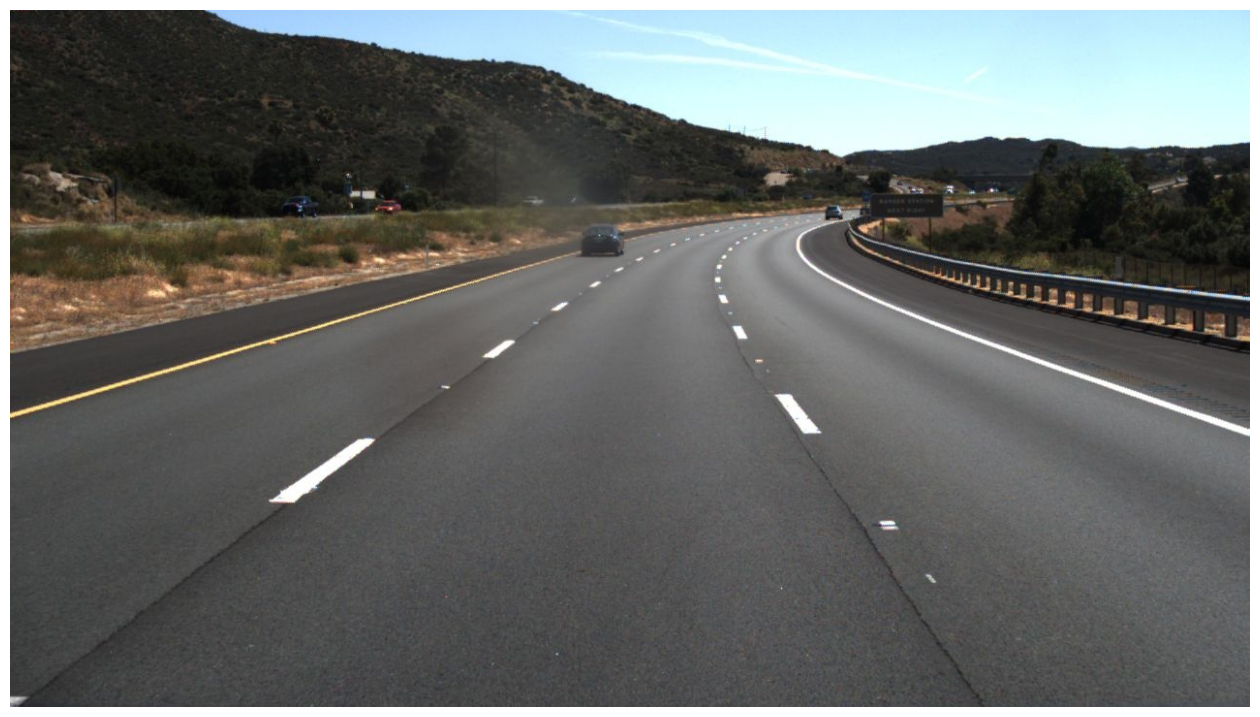

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/Euro-Truck-Simulator-2-Lane-Assist/plugins/UFLDLaneDetection/UFLD/lanes/7.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(img[:, :, ::-1])
plt.axis("off")
plt.show()

### Inference

In [ ]:
input_tensor = laneDetector.prepare_input(img)

output = laneDetector.infer.inference(input_tensor)

lanes_points, lanes_detected = laneDetector.process_output(output, laneDetector.cfg, original_image_width =  laneDetector.img_width, original_image_height = laneDetector.img_height)

laneDetector.lanes_points = lanes_points
laneDetector.lanes_detected = lanes_detected

print(lanes_points)
print(lanes_detected)

[[(0, 422), (32, 410), (64, 402), (96, 393), (128, 383), (160, 373), (192, 362), (224, 354), (256, 343), (288, 332), (320, 323), (352, 315), (384, 306), (416, 296), (448, 285), (480, 279), (512, 271), (544, 262), (576, 252), (608, 243), (640, 235), (672, 228)], [(726, 229), (690, 240), (665, 250), (645, 260), (628, 270), (621, 280), (599, 290), (584, 300), (565, 310), (550, 320), (538, 330), (521, 340), (509, 350), (496, 360), (483, 369), (468, 380), (453, 390), (435, 400), (421, 410), (405, 420), (391, 430), (373, 440), (360, 450), (346, 459), (334, 470), (321, 480), (306, 490), (292, 500), (279, 510), (265, 520), (251, 530), (236, 540), (224, 550), (210, 560), (196, 570), (184, 580), (169, 590), (149, 600), (135, 610), (120, 620), (101, 630), (87, 640), (73, 650), (61, 660), (47, 670), (42, 680), (21, 690), (11, 700)], [(829, 220), (807, 229), (770, 240), (794, 250), (752, 260), (741, 270), (733, 280), (734, 290), (744, 300), (746, 310), (756, 320), (756, 330), (765, 340), (768, 350)

### Visualize

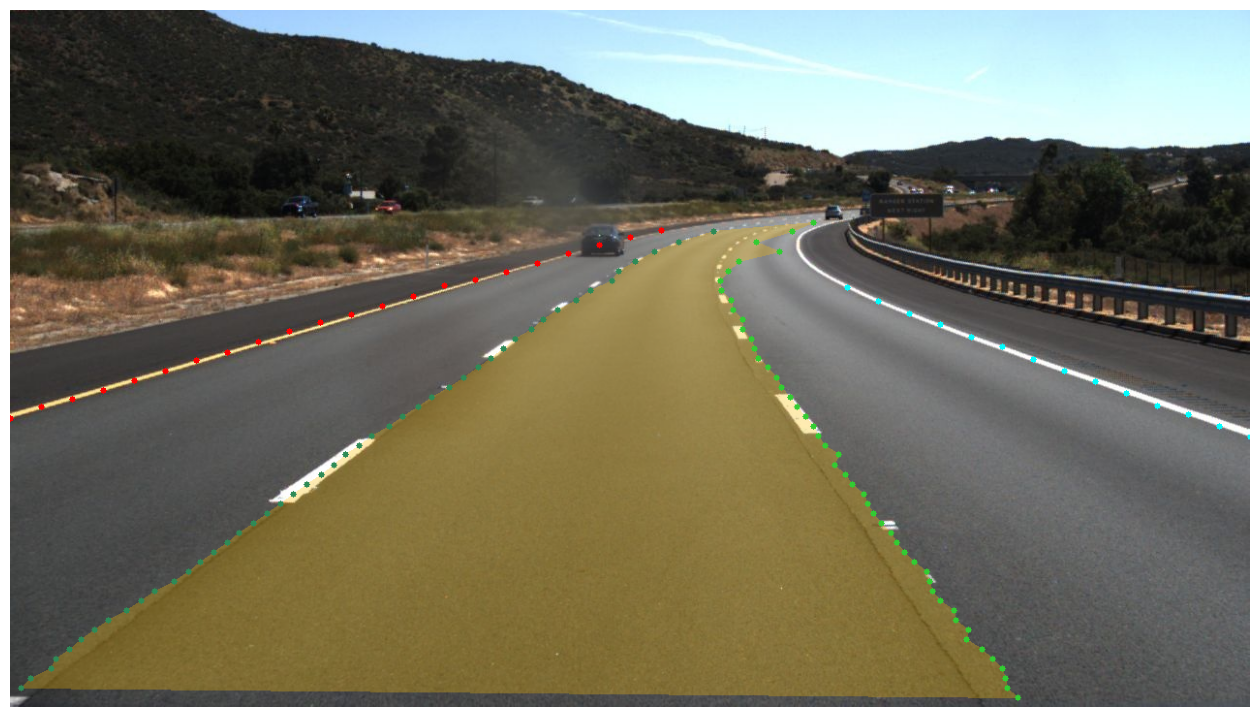

In [ ]:
result_img = laneDetector.draw_lanes(img[:, :, ::-1], lanes_points, lanes_detected, True, original_image_width =  img.shape[1], original_image_height = img.shape[0])

plt.figure(figsize=(16, 10))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.imshow(result_img)

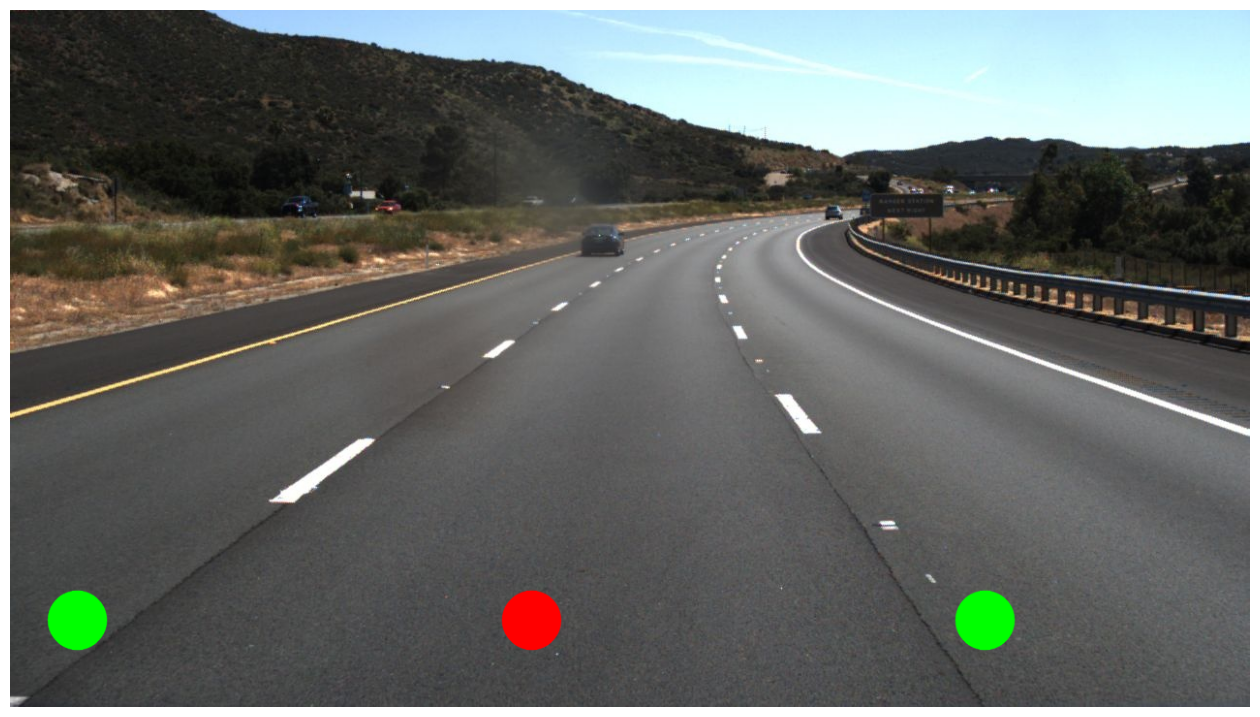

In [ ]:
farLeftLane = lanes_points[0]
leftLane = lanes_points[1]
rightLane = lanes_points[2]
farRightLane = lanes_points[3]

leftLanePoints = leftLane[len(leftLane)-10:len(leftLane)]
rightLanePoints = rightLane[len(rightLane)-10:len(rightLane)]
leftLaneX = np.mean(leftLanePoints, axis=0)[0]
rightLaneX = np.mean(rightLanePoints, axis=0)[0]

frame = img.copy()

w = frame.shape[1]
h = frame.shape[0]

difference = (rightLaneX - leftLaneX) / 2
difference = difference + leftLaneX

cv2.circle(frame, (int(leftLaneX), int(h/8*7)), 30, (0,255,0), -1, cv2.LINE_AA)
cv2.circle(frame, (int(rightLaneX), int(h/8*7)), 30, (0,255,0), -1, cv2.LINE_AA)
cv2.circle(frame, (int(difference), int(h/8*7)), 30, (0,0,255), -1, cv2.LINE_AA)

plt.figure(figsize=(16, 10))
plt.imshow(frame[:, :, ::-1])
plt.axis("off")
plt.show()

## Video

In [ ]:
!wget https://raw.githubusercontent.com/kairess/toy-datasets/master/lane_assist.mp4

--2023-10-13 05:50:02--  https://raw.githubusercontent.com/kairess/toy-datasets/master/lane_assist.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25268015 (24M) [application/octet-stream]
Saving to: ‘lane_assist.mp4’

lane_assist.mp4     100%[===================>]  24.10M  --.-KB/s    in 0.09s   

2023-10-13 05:50:04 (276 MB/s) - ‘lane_assist.mp4’ saved [25268015/25268015]



In [ ]:
from google.colab import files

cap = cv2.VideoCapture("lane_assist.mp4")

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    input_tensor = laneDetector.prepare_input(img)

    output = laneDetector.infer.inference(input_tensor)

    lanes_points, lanes_detected = laneDetector.process_output(output, laneDetector.cfg, original_image_width =  laneDetector.img_width, original_image_height = laneDetector.img_height)

    laneDetector.lanes_points = lanes_points
    laneDetector.lanes_detected = lanes_detected

    result_img = laneDetector.draw_lanes(img, lanes_points, lanes_detected, True, original_image_width =  img.shape[1], original_image_height = img.shape[0])

    out.write(result_img)

out.release()

files.download('/content/output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

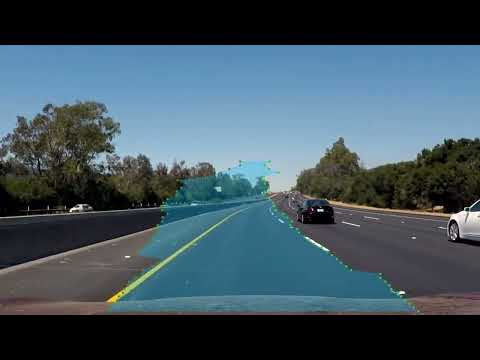

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('9mKubBPsKWU', width=1280, height=720)